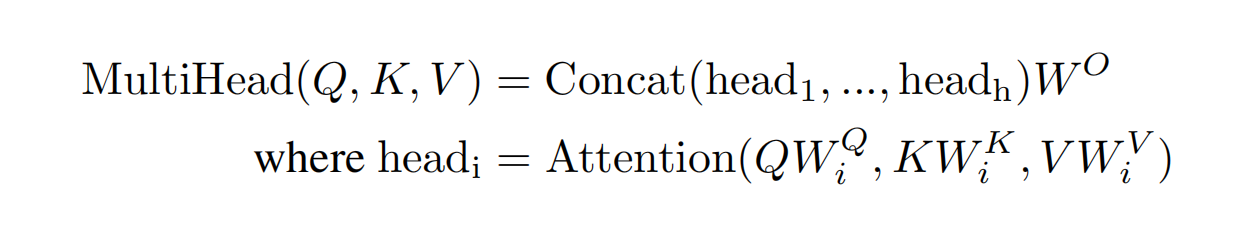

In [ ]:
import math
import torch
import torch.nn as nn

class MutiheadSelfAttentionFormal(nn.Module):
    def __init__(self, hidden_dim, head_num, dropout_rate = 0.1) -> None:
        super().__init__()
        self.hidden_dim = hidden_dim
        self.head_num = head_num

        self.head_dim = hidden_dim // head_num

        self.query = nn.Linear(hidden_dim, hidden_dim)
        self.key = nn.Linear(hidden_dim, hidden_dim)
        self.value = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, hidden_dim)

        self.attention_dropout = nn.Dropout(dropout_rate) # gpt2和bert有，但是llama没有

    def forward(self, X, attention_mask = None):
        batch_size, seq_length, _ = X.size()

        Q = self.query(X)
        K = self.key(X)
        V = self.value(X) # shape is (b, s, h), h = head_num * head_dim
        
        # (b, s, h) -> (b, head_num, s, head_dim)
        q_state = Q.view(batch_size, seq_length, self.head_num, self.head_dim).transpose(1, 2)
        k_state = K.view(batch_size, seq_length, self.head_num, self.head_dim).transpose(1, 2)
        v_state = V.view(batch_size, seq_length, self.head_num, self.head_dim).transpose(1, 2)

        attention_score = q_state @ k_state.transpose(-1, 2) / math.sqrt(self.head_dim)
        # k_state.transpose(-1, 2)之后形状变为（b, head_num, head_dim, s）
        # attention_score形状是（b, head_num, s, s）
        if attention_mask is not None:
            attention_score = attention_score.masked_fill(
                attention_mask == 0,
                float("-inf")
            )

        attention_weight = torch.softmax(
            attention_score,
            dim=-1
        ) 
        print(attention_weight)
        attention_weight = self.attention_dropout(attention_weight)
        output_mid = attention_weight @ v_state # (b, head_num, s, head_dim)
        output_mid = output_mid.transpose(1, 2).contiguous() # contiguous让内存连续
        output_mid = output_mid.view(batch_size, seq_length, -1) # 这一步就是concat操作
        output = self.out(output_mid)
        return output

attention_mask = torch.tensor(
    [
        [1, 1],
        [0, 1],
        [1, 0]
    ]
).unsqueeze(dim=1).unsqueeze(dim=2).expand(3, 8, 2, 2) 
# 将 mask 扩展为 (3, 8, 2, 2)，适配多头注意力（8 个头），每个头都用同样的 mask，
# 得到一个形状为 (batch_size, head_num, seq_length, seq_length) 的掩码，
# 可以用于屏蔽注意力分数中无效的位置
print("attention_mask: ", attention_mask)
X = torch.rand(3, 2, 128)
net = MutiheadSelfAttentionFormal(128, 8)
net(X, attention_mask) # 即输出：MutiHead(Q, K, V)

attention_mask:  tensor([[[[1, 1],
          [1, 1]],

         [[1, 1],
          [1, 1]],

         [[1, 1],
          [1, 1]],

         [[1, 1],
          [1, 1]],

         [[1, 1],
          [1, 1]],

         [[1, 1],
          [1, 1]],

         [[1, 1],
          [1, 1]],

         [[1, 1],
          [1, 1]]],


        [[[0, 1],
          [0, 1]],

         [[0, 1],
          [0, 1]],

         [[0, 1],
          [0, 1]],

         [[0, 1],
          [0, 1]],

         [[0, 1],
          [0, 1]],

         [[0, 1],
          [0, 1]],

         [[0, 1],
          [0, 1]],

         [[0, 1],
          [0, 1]]],


        [[[0, 0],
          [0, 0]],

         [[0, 0],
          [0, 0]],

         [[0, 0],
          [0, 0]],

         [[0, 0],
          [0, 0]],

         [[0, 0],
          [0, 0]],

         [[0, 0],
          [0, 0]],

         [[0, 0],
          [0, 0]],

         [[0, 0],
          [0, 0]]]])
tensor([[[[0.5113, 0.4887],
          [0.5082, 0.4918]],

        

tensor([[[-1.5458e-01,  2.9873e-01,  2.8931e-01,  1.5166e-02, -1.1267e-01,
           2.2335e-02,  2.5791e-01,  5.5988e-01, -4.6995e-01, -2.0980e-01,
           9.8552e-02, -2.8138e-01, -1.1476e-01,  1.2399e-01,  2.4714e-01,
           1.4954e-02,  6.6562e-02,  4.9993e-02, -4.1952e-02,  3.4395e-02,
          -3.2283e-01,  8.3625e-02, -6.5360e-02, -8.3834e-02,  2.0844e-02,
          -9.6010e-02, -4.2144e-01,  1.2079e-02,  3.6189e-01, -2.1418e-01,
          -4.1094e-01,  6.6328e-03,  2.5764e-03,  7.7872e-02, -1.6132e-01,
          -1.3185e-01, -2.5617e-01, -1.6625e-01, -1.4215e-02,  9.4703e-04,
          -1.4455e-01,  5.0177e-01,  3.0950e-01,  2.7303e-02,  7.6776e-02,
           5.2306e-01, -6.6123e-01, -1.3090e-01,  1.4132e-01, -7.5957e-02,
          -2.1768e-01,  3.0981e-01, -1.8011e-02, -5.3436e-02,  1.4945e-02,
           1.9430e-01,  4.8637e-01, -4.2333e-02,  8.1258e-02, -4.2554e-01,
          -1.3684e-01, -1.7668e-01, -3.1432e-02, -2.0911e-01, -1.0098e-01,
           3.0238e-01,  1